In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as py
import numpy as np
from imp import reload
import pixie_read_st as pxr
import FSA 

In [2]:
import master_read as m
import efit_plots as e

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['text.usetex']=True
plt.rcParams['animation.html'] = 'html5'

## EFIT part

In [4]:
efitpath = "/users/giannis_kx/eqdsks/Equidisk__SN_15MA_Tped_4.4_keV__referenc_ABT4ZL_v1_0"

In [5]:
m.read_geqdsk(efitpath);

Case Info: ['TEQ', 'g', '03/20/2012', '#900032', '230s', '3']
nw: 257
nh: 513
rdim: 7.0
zdim: 12.0
rleft: 3.0
zmid: 0.0
rmaxis: 6.3465077
zmaxis: 0.642944493
simag: -12.2397459
sibry: 0.0686481342
rcentr: 6.5
bcentr: -5.3
current: 15000195.6
fpol: 257
pres: 257
ffprim: 257
pprime: 257
psirz: (513, 257)
qpsi: 257
nbbbs: 927
limitr: 56
rbbbs: 927
zbbbs: 927
rlim: 56
zlim: 56
kvtor: 0.0
End of File
rvtor: 0.0
nmass: 0.0


In [6]:
m.struct_hor_ax_det()
e.gridsNunits()

In [7]:
psiNormGrid = e.psi_norm

## Pixie3D part

In [8]:
reload(pxr)

<module 'pixie_read_st' from '/turquoise/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [11]:
filepath = "/net/scratch4/giannis_kx/pixie3d/iter/int_kink/orig/orig.scratch/"

In [12]:
pxr.pixieload(filepath + "pixie3d.h5")

timesteps= 614
Dictionary of terms:
Variables: ['Car_variables', 'Cnv_variables', 'Cov_variables', 'Diagnostics', 'Perturbations', 'cells', 'nodes']
Cartesian: ['Bx', 'By', 'Bz', 'Jx', 'Jy', 'Jz', 'Prs', 'Ve_1', 'Ve_2', 'Ve_3', 'Vx', 'Vy', 'Vz', 'rho']
Contravariant: ['B^1', 'B^2', 'B^3', 'J*P^2', 'J.(pi+pe)', 'J.Rho', 'J^1', 'J^2', 'J^3', 'P^1', 'P^3']
Covariant: ['B_1', 'B_2', 'B_3', 'J_1', 'J_2', 'J_3', 'T=Te+Ti', 'V_1', 'V_2', 'V_3', 'rho']
Diagnostic: ['E_1', 'E_2', 'E_3', 'Int. heat src', 'Poloidal flux', 'Ti+Te', 'chi par', 'chi perp', 'diff', 'eta', 'lambda', 'local div(B)', 'local div(J)', 'local div(V)', 'nu', 'q factor']
Perturbations: ['B^1_pert', 'B^2_pert', 'B^3_pert', 'P^1_pert', 'P^2_pert', 'P^3_pert', 'Prs_pert', 'Rho_pert']
Cell: ['X', 'Y', 'Z']
Node: ['X', 'Y', 'Z']


In [13]:
# contravariant B-field
B1 = np.squeeze(pxr.load_array(1,0,None,1))
B2 = np.squeeze(pxr.load_array(1,1,None,1))
B3 = np.squeeze(pxr.load_array(1,2,None,1))
# covariant B-field
B_1 = np.squeeze(pxr.load_array(2,0,None,1))
B_2 = np.squeeze(pxr.load_array(2,1,None,1))
B_3 = np.squeeze(pxr.load_array(2,2,None,1))
# Cartesian B-field
Bx = np.squeeze(pxr.load_array(0,0,None,1))
By = np.squeeze(pxr.load_array(0,1,None,1))
Bz = np.squeeze(pxr.load_array(0,2,None,1))
# Flux and toroidal current
psi_pol = np.squeeze(pxr.load_array(3,4,None,1))
J3 = np.squeeze(pxr.load_array(2,5,None,1))

In [14]:
psit = np.mean(psi_pol,axis=2)

In [15]:
pxr.Grid_for_Cell_Interpolation(B1)
pxr.Axes_of_Interpolation(psi_pol)
pxr.Grid_Cell_Interpolations(B1,B2,B3,J3)
pxr.Grid_Cell_Interpolations_Covariant(B_1,B_2,B_3)
pxr.MeshGrids_Creation()
B1,B2,B3,J3 = pxr.C2N_Evaluations()
B_1,B_2,B_3 = pxr.C2N_Evaluations_Covariant()
pxr.Grid_Interpolations(psit,B1,B2,B3,J3)

Logical Grid Interpolations done. All array (A) interpolators take A_int.


In [16]:
# Jacobian Calculation
Bsq = Bx*Bx + By*By + Bz*Bz
Bsq_ov_Jac = B1*B_1 + B2*B_2 + B3*B_3
Jac = Bsq_ov_Jac/Bsq

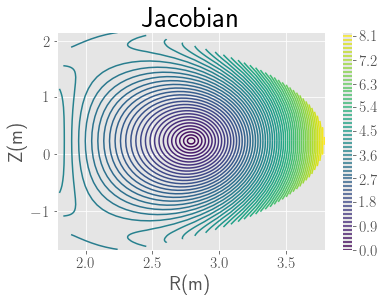

In [17]:
plt.title("Jacobian")
plt.contour(pxr.X[:,:,0],pxr.Z[:,:,0],Jac[:,:,0],60)
plt.colorbar()
plt.xlabel("R(m)")
plt.ylabel("Z(m)")
plt.show()

In [18]:
from scipy.interpolate import RegularGridInterpolator

In [24]:
from scipy.interpolate import interp1d

In [133]:
def FSA_numerator(A,jac):
    integrand = jac*A
    numerator = np.zeros(integrand.shape[0])
    for i in range(integrand.shape[0]):
        numerator[i] = Dromb(integrand,i)
    return numerator

In [134]:
def FSA(A,jac):
    numerator = FSA_numerator(A,jac)
    denominator = FSA_denominator(jac)
    fsa = numerator/denominator
    return fsa

In [19]:
Jac_int = RegularGridInterpolator((pxr.r,pxr.theta,pxr.phi), Jac[:,:,:], method='linear', bounds_error=False, fill_value = 0)
J3_int = RegularGridInterpolator((pxr.r,pxr.theta,pxr.phi), J3[:,:,:], method='linear', bounds_error=False, fill_value = 0)

In [20]:
J3_fsa = FSA.FSA(J3,Jac)

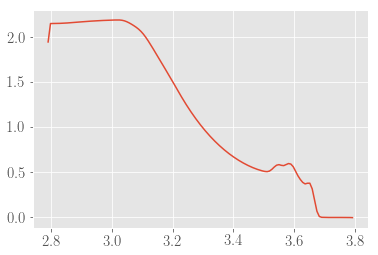

In [21]:
plt.plot(pxr.X[:,0,0],-J3_fsa)
plt.show()

In [22]:
B1t = np.mean(B1,axis=2)
B2t = np.mean(B2,axis=2)
B3t = np.mean(B3,axis=2)

In [25]:
J3_fsa_int = interp1d(pxr.r,J3_fsa)

In [26]:
pxr.Calculation_of_Units_and_Sizes()

Units and sizes calculated.


In [27]:
psi_min, norm = pxr.Normalization_numbers(psit,B1t,B2t)

/usr/projects/hpcsoft/toss3/common/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


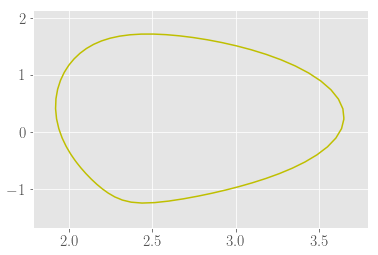

In [28]:
r_of_psi_arr, rmaxis, umaxis = pxr.create_r_psi_list(psit,B1t,B2t)

In [29]:
rs = r_of_psi_arr
ps = np.linspace(0,1,num=101)

In [30]:
r_p = interp1d(ps,rs)

In [31]:
efit_rs = r_p(psiNormGrid)

In [32]:
J3_fsa_grid = np.squeeze(J3_fsa_int(efit_rs))

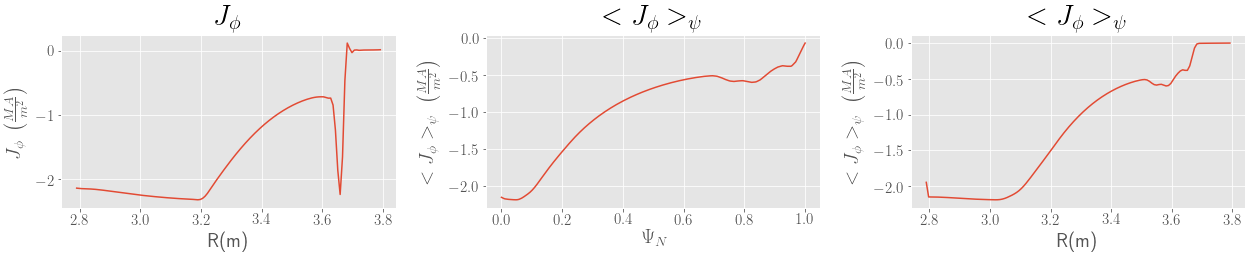

In [33]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (18,4))
ax1.set_title(r"$J_{\phi}$")
ax1.set_xlabel("R(m)")
ax1.set_ylabel(r"$J_{\phi}\;\left(\frac{MA}{m^2}\right)$")
ax1.plot(pxr.X[:,0,0],J3[:,0,0])
ax2.set_title(r"$<J_{\phi}>_{\psi}$")
ax2.set_xlabel(r"$\Psi_N$")
ax2.set_ylabel(r"$<J_{\phi}>_{\psi}\;\left(\frac{MA}{m^2}\right)$")
ax2.plot(psiNormGrid,J3_fsa_grid)
ax3.set_title(r"$<J_{\phi}>_{\psi}$")
ax3.set_xlabel("R(m)")
ax3.set_ylabel(r"$<J_{\phi}>_{\psi}\;\left(\frac{MA}{m^2}\right)$")
ax3.plot(pxr.X[:,0,0],J3_fsa)
plt.tight_layout()
plt.show()

In [34]:
np.save(filepath+"J3FSA",J3_fsa_grid)